# Population changes in the Czech republic
I used data from the Czech Statistical Office (Český statistický úřad) by creating my own database with the data i was interested in.  
you can do this yourself on https://vdb.czso.cz/vdbvo2/faces/cs/index.jsf?page=uziv-dotaz#  
This project focuses on population changes in the Czech republic and it's regions and other related data.  
More specifically, it focuses on population change, number of deaths, number of births, average age of mothers, mortality rate and the number of abortions. 


# Loading the XML data and parsing it
I parsed the XML files using the xml.etree.ElementTree and then by manually checking the structure of the tree.  
At the time i was parsing the XML files, i did not find a better way as how to process the data. There might be a better way, for example using the  
```pd.read_xml(file)```  
I already processed the data when i found this function, so i didn't need to work with this function at all.  

In [1]:
# Specifying all the xml files
import xml.etree.ElementTree as ET
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import urllib.request

# List of XML files
xml_files = [
    "CR",
    "Jihocesky",
    "Jihomoravsky",
    "Karlovarsky",
    "Praha",
    "Kralovehradecky",
    "Liberecky",
    "Moravskoslezsky",
    "Olomoucky",
    "Pardubicky",
    "Plzensky",
    "Stredocesky",
    "Ustecky",
    "Vysocina",
    "Zlinsky"
]

# Dictionary to store data from XML files
data = {}

# Loop through each XML file
for xml_file in xml_files:
    # Parse XML file
    tree = ET.parse("data/" + xml_file + ".xml")
    root = tree.getroot()
    
    # Extract data as needed, here we're just storing the root element
    data[xml_file] = root

In [2]:
# Manually saving the XML data into a dictionary
uzemi = {}

for file in xml_files:
    ukazatel = {}
    vecneUpresneni_typ = {}
    vecneUpresneni_text = {}
    obdobi = {}

    # You can also iterate over child elements of a specific element:
    for child in data[file]:
        #print(child.tag)
        # metaSlovnik
        # udaj
        if child.tag == '{http://vdb.czso.cz/xml/export}metaSlovnik':
            for sub_child in child:
                #print(sub_child.tag, sub_child.text)
                if sub_child.tag == '{http://vdb.czso.cz/xml/export}ukazatel':
                    #print(sub_child.tag)
                    for sub_sub_child in sub_child:
                        #print(sub_sub_child.tag, sub_sub_child.text)
                        if sub_sub_child.tag == '{http://vdb.czso.cz/xml/export}uka':
                            #print(sub_sub_child.tag)
                            for sub_sub_sub_child in sub_sub_child:
                                if sub_sub_sub_child.tag == '{http://vdb.czso.cz/xml/export}text':
                                    #print(sub_sub_child.get('ID'), sub_sub_sub_child.text) # Výpis názvu ukazatele
                                    ukazatel[sub_sub_child.get('ID')] = sub_sub_sub_child.text
                                    pass
                if sub_child.tag == '{http://vdb.czso.cz/xml/export}vecneUpresneni':
                    for sub_sub_child in sub_child:
                        #print(sub_sub_child.get('ID'))
                        if sub_sub_child.tag == '{http://vdb.czso.cz/xml/export}element':
                            for sub_sub_sub_child in sub_sub_child:
                                if (sub_sub_sub_child.tag == '{http://vdb.czso.cz/xml/export}dimText'):
                                    #print(sub_sub_sub_child.text)
                                    vecneUpresneni_typ[sub_sub_child.get('ID')] = sub_sub_sub_child.text
                                    pass
                                if sub_sub_sub_child.tag == '{http://vdb.czso.cz/xml/export}text':
                                    #print(sub_sub_sub_child.text)
                                    vecneUpresneni_text[sub_sub_child.get('ID')] = sub_sub_sub_child.text
                                    pass
                if sub_child.tag == '{http://vdb.czso.cz/xml/export}obdobi':
                    for sub_sub_child in sub_child:
                        #print(sub_sub_child.tag, sub_sub_child.text)
                        casOd = None
                        casDo = None
                        for sub_sub_sub_child in sub_sub_child:
                            #print(sub_sub_child.get('ID'), sub_sub_sub_child.tag, sub_sub_sub_child.text)
                            if sub_sub_sub_child.tag == '{http://vdb.czso.cz/xml/export}casOd':
                                casOd = sub_sub_sub_child.text
                                #print(sub_sub_sub_child.tag, sub_sub_sub_child.text)
                            if sub_sub_sub_child.tag == '{http://vdb.czso.cz/xml/export}casDo':
                                casDo = sub_sub_sub_child.text
                                #print(sub_sub_sub_child.tag, sub_sub_sub_child.text)
                            obdobi[sub_sub_child.get('ID')] = [casOd, casDo]
                        #print(sub_sub_child.get('ID'), obdobi[sub_sub_child.get('ID')])

        # Convert obdobi to dateTime
        for key, value in obdobi.items():
            year = 2024 - int(key[1:]) 
            obdobi[key] = year 
        # You can also iterate over child elements of a specific element:

        # Celkový přírůstek/úbytek

        # the years might not align

        population_change = {
            'Total': [],
            'Men': [],
            'Women': []    
        } # population_change general

        children_born = {
            'Total': [],
            'Men': [],
            'Women': [],
            'First child': [],
            'Second child': [],
            'Third child': [],
            'Fourth + child': [],
            'Out of wedlock': []
        } # children_born general


        # deaths and causes
        # 'v8': 'Některé infekční a parazitární nemoci (A00–B99)', 'v9': 'Novotvary (C00–D48)', 'v10': 'Nemoci krve a krvetvorných orgánů a některé poruchy imunity (D50–D89)', 
        #'v11': 'Nemoci endokrinní, výživy a přeměny látek (E00–E90)', 'v12': 'Nemoci oběhové soustavy (I00–I99)', 'v13': 'Poruchy duševní a poruchy chování (F00–F99)', 
        #'v14': 'Nemoci nervové soustavy (G00–G99)', 'v15': 'Nemoci oka a očních adnex (H00–H59)', 'v16': 'Nemoci ucha a bradavkového výběžku (H60–H95)', 'v17': 'Nemoci dýchací soustavy (J00–J99)', 
        #'v18': 'Nemoci trávicí soustavy (K00–K93)', 'v19': 'Nemoci kůže a podkožního vaziva (L00–L99)', 'v20': 'Nemoci svalové a kosterní soustavy a pojivové tkáně (M00–M99)', 
        #'v21': 'Nemoci močové a pohlavní soustavy (N00–N99)', 'v22': 'Poranění, otravy a některé jiné následky vnějších příčin (S00–T98)', 'v23': 'Těhotenství, porod a šestinedělí (O00–O99)', 
        #'v24': 'Některé stavy vzniklé v perinatálním období (P00–P96)', 'v25': 'Vrozené vady, deformace a chromozomální abnormality (Q00–Q99)', 
        #'v26': 'Příznaky, znaky a abnormální klinické a laboratorní nálezy nezařazené jinde (R00–R99)', 'v27': 'Vnější příčiny nemocnosti a úmrtnosti (V01–Y98)', 
        #'v28': 'Kódy pro speciální účely (U00–U85)', 'v29': 'COVID–19'
        deaths = {
            'Total': [],
            'Men': [],
            'Women': [],
            'Parasite illnesses': [],
            'Tumors': [],
            'Blood illnesses': [],
            'Endocrine nutrition metabolism': [],
            'Circulatory system': [],
            'Mental disorders': [],
            'Nervous system': [],
            'Eye illnesses': [],
            'Ear illnesses': [],
            'Respiratory system': [],
            'Digestive system': [],
            'Skin illnesses': [],
            'Muscle skeletal system': [],
            'Urinary reproductive system': [],
            'Injuries poisoning': [],
            'Injuries Pregnancy birth postpartum': [],
            'Perinatal conditions': [],
            'Congenital deformities': [],
            'Symptoms signs abnormal findings': [],
            'External causes': [],
            'COVID-19': []
        } # deaths general

        child_deaths = {
            'Infant': [],
            'Newborn': []
        }
        age_of_mother_on_child_birth = {
            'Total': [],
            'First child': [],
            'Second child': [],
            'Third child': []
        }

        deaths_by_age = {
            '0-14': [],
            '15-64': [],
            '65+': []
        }

        abortions = []

        # print(child.tag)
        # metaSlovnik
        # data
        if child.tag == '{http://vdb.czso.cz/xml/export}data':
            for sub_child in child:
                uka = sub_child.find('{http://vdb.czso.cz/xml/export}uka')
                value = sub_child.find('{http://vdb.czso.cz/xml/export}hod')
                typ = sub_child.find('{http://vdb.czso.cz/xml/export}vec')
                cas = sub_child.find('{http://vdb.czso.cz/xml/export}cas')

                if uka.text == 'u1':
                    if typ is None:
                        population_change['Total'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v2':
                        population_change['Men'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v3':
                        population_change['Women'].append((int(value.text), obdobi[cas.text]))
                elif uka.text == 'u2' or uka.text == 'u5':
                    if typ.text == 'v33':
                        children_born['Total'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v1':
                        children_born['Out of wedlock'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v2':
                        children_born['Men'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v3':
                        children_born['Women'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v4':
                        children_born['First child'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v5':
                        children_born['Second child'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v6':
                        children_born['Third child'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v7':
                        children_born['Fourth + child'].append((int(value.text), obdobi[cas.text]))
                elif uka.text == 'u3':
                    if typ is None:
                        deaths['Total'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v2':
                        deaths['Men'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v3':
                        deaths['Women'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v8':
                        deaths['Parasite illnesses'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v9':
                        deaths['Tumors'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v10':
                        deaths['Blood illnesses'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v11':
                        deaths['Endocrine nutrition metabolism'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v12':
                        deaths['Circulatory system'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v13':
                        deaths['Mental disorders'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v14':
                        deaths['Nervous system'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v15':
                        deaths['Eye illnesses'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v16':
                        deaths['Ear illnesses'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v17':
                        deaths['Respiratory system'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v18':
                        deaths['Digestive system'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v19':
                        deaths['Skin illnesses'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v20':
                        deaths['Muscle skeletal system'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v21':
                        deaths['Urinary reproductive system'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v22':
                        deaths['Injuries poisoning'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v23':
                        deaths['Injuries Pregnancy birth postpartum'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v24':
                        deaths['Perinatal conditions'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v25':
                        deaths['Congenital deformities'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v26':
                        deaths['Symptoms signs abnormal findings'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v27':
                        deaths['External causes'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v29':
                        deaths['COVID-19'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v30':
                        deaths_by_age['0-14'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v31':
                        deaths_by_age['15-64'].append((int(value.text), obdobi[cas.text]))
                    elif typ.text == 'v32':
                        deaths_by_age['65+'].append((int(value.text), obdobi[cas.text]))
                elif uka.text == 'u4':
                    child_deaths['Infant'].append((float(value.text), obdobi[cas.text]))
                elif uka.text == 'u7':
                    child_deaths['Newborn'].append((float(value.text), obdobi[cas.text]))
                elif uka.text == 'u6':
                    if typ is None:
                        age_of_mother_on_child_birth['Total'].append((float(value.text), obdobi[cas.text]))
                    elif typ.text == 'v4':
                        age_of_mother_on_child_birth['First child'].append((float(value.text), obdobi[cas.text]))
                    elif typ.text == 'v5':
                        age_of_mother_on_child_birth['Second child'].append((float(value.text), obdobi[cas.text]))
                    elif typ.text == 'v6':
                        age_of_mother_on_child_birth['Third child'].append((float(value.text), obdobi[cas.text]))
                    elif typ.text == 'v7':
                        age_of_mother_on_child_birth['Fourth + child'].append((float(value.text), obdobi[cas.text]))
                elif uka.text == 'u8':
                    abortions.append((int(value.text), obdobi[cas.text]))
    
    uzemi[file] = { 'Pointer': ukazatel, 
                    'Specification-type': vecneUpresneni_typ, 
                    'Specification-text': vecneUpresneni_text, 
                    'Population change': population_change,
                    'Births': children_born,
                    'Deaths': deaths,
                    'Deaths by age': deaths_by_age,
                    'Mortality rate': child_deaths,
                    'Age of mother on birth': age_of_mother_on_child_birth,
                    'Abortions': abortions
                    }


# Population Change
### We  can see the start of war on Ukraine, I am unsure about the spike around 2007, but that year we entered the Schengen area, and there was increased tension in the Middle East

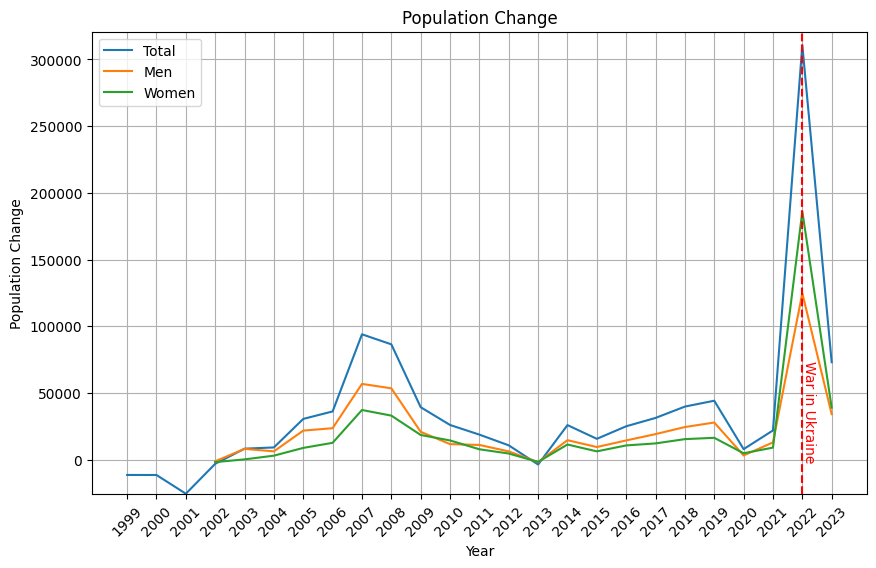

In [3]:
# Population change
population_change = uzemi['CR']['Population change']

min_value, max_value = 0, 0
plt.figure(figsize=(10, 6))
for key in population_change:
    # Separate the values and the years into two lists 
    values, years = zip(*population_change[key])
    if key == 'Total':
        min_value = min(values)
        max_value = max(values)
    plt.plot(years, values, label=key)

plt.title('Population Change')
plt.xlabel('Year')
plt.ylabel('Population Change')

plt.axvline(x=2022, color='red', linestyle='--')
plt.text(2022, 0, 'War in Ukraine', color='red', rotation=-90)

plt.xticks(range(1999, 2024))
plt.xticks(rotation=45)
plt.grid()
plt.ylim(min_value, max_value + 10000)
plt.legend()
plt.show()

Here we can sadly see how Ukrainian women moved to the Czech republic, whereas the men stayed in Ukraine because of the war

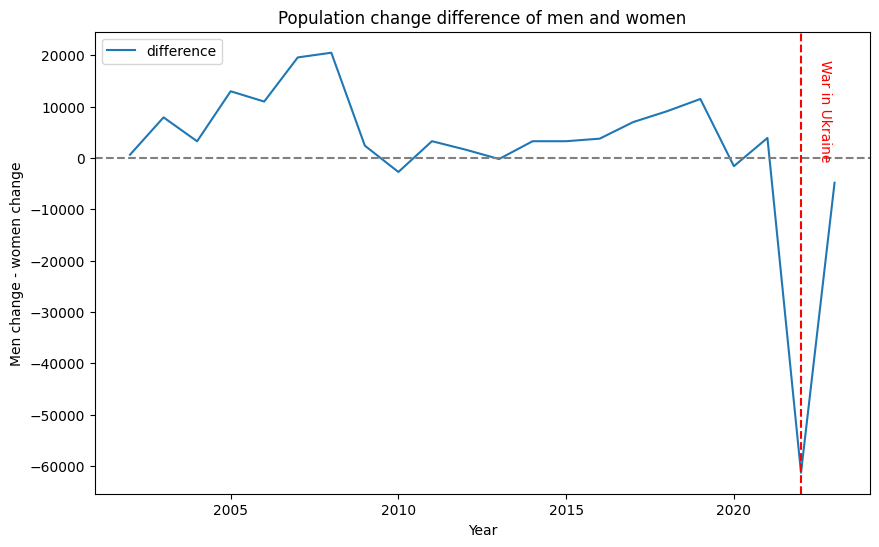

In [4]:
# Population change difference of men and women
male_to_female_difference = []
for value in population_change['Men']:
    male_to_female_difference.append(value[0])
i = 0

for value in population_change['Women']:
    male_to_female_difference[i] -= value[0]
    i += 1
# deaths
# Separate the values and the years into two lists 
values, years = zip(*population_change['Men'])

plt.figure(figsize=(10, 6))
plt.plot(years, male_to_female_difference, label='difference')

plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=2022, color='red', linestyle='--')
plt.text(2022.5, -100, 'War in Ukraine', color='red', rotation=-90)

plt.title('Population change difference of men and women')
plt.xlabel('Year')
plt.ylabel('Men change - women change')
plt.legend()
plt.show()

The difference between men and women seems to be gradually increasing even without the Covid-19 increase of dead men. This could be because of a several reasons, the simplest one being that the population increased over the years, so the difference did aswell.

In [5]:
# Population change on Czech map
region_codes = {
    'Praha': 'CZ-10',
    'Jihomoravsky': 'CZ-64',
    'Karlovarsky': 'CZ-41',
    'Jihocesky': 'CZ-31',
    'Stredocesky': 'CZ-20',
    'Zlinsky': 'CZ-72',
    'Ustecky': 'CZ-42',
    'Vysocina': 'CZ-63',
    'Liberecky': 'CZ-51',
    'Olomoucky': 'CZ-71',
    'Pardubicky': 'CZ-53',
    'Moravskoslezsky': 'CZ-80',
    'Kralovehradecky': 'CZ-52',
    'Plzensky': 'CZ-32'
}

population_change = {}
for key in uzemi:
    if key == 'CR':
        continue
    values, years = zip(*uzemi[key]['Population change']['Total'])
    values = np.array(values, dtype=float)
    population_change[region_codes[key]] = sum(values)

A better representation of the regions so that we can see which regions were regions of interest in the last years 24 years (2000-2023)

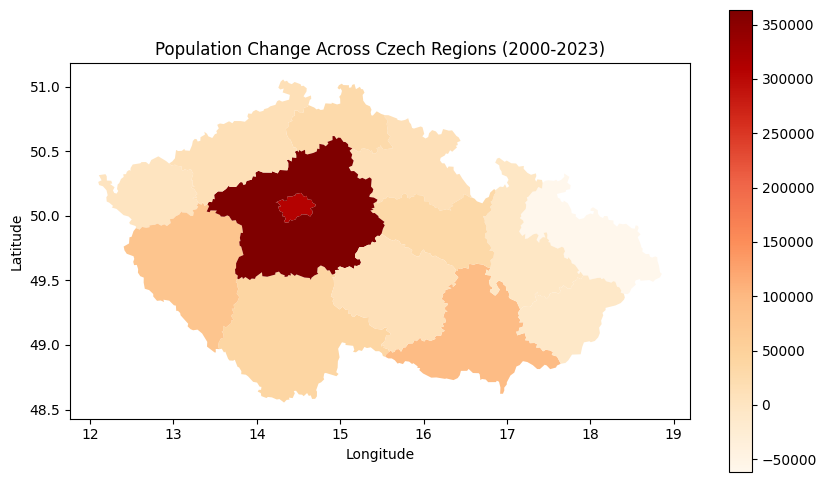

In [6]:
# Population change on Czech map
population_change_df = pd.DataFrame(list(population_change.items()), columns=['ISO3166-2', 'Population Change'])
# Step 1: Read the map of Czech regions
url_czech_regions_map = 'https://raw.githubusercontent.com/Plavit/Simple-Dash-Plotly-Map-Czech-Regions/main/maps/czech-regions-low-res.json'
with urllib.request.urlopen(url_czech_regions_map) as f:
    czech_regions_map = geopandas.read_file(f)

# Step 3: Merge the population change data with the map data
population_change_merge = pd.merge(population_change_df, czech_regions_map, on='ISO3166-2')
population_change_geo=geopandas.GeoDataFrame(population_change_merge)

# Plot the map
population_change_geo.plot(column='Population Change', cmap='OrRd', legend=True, figsize=(10, 6))
plt.title('Population Change Across Czech Regions (2000-2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

*If we calculate the population change using births - deaths, the numbers are going to be lower, because immigration is not calculated in births, however, when immigrating people recieve permanent or long-term residence, they are calculated in the deaths.*
This means, that the numbers are going to be lower than they really are.  

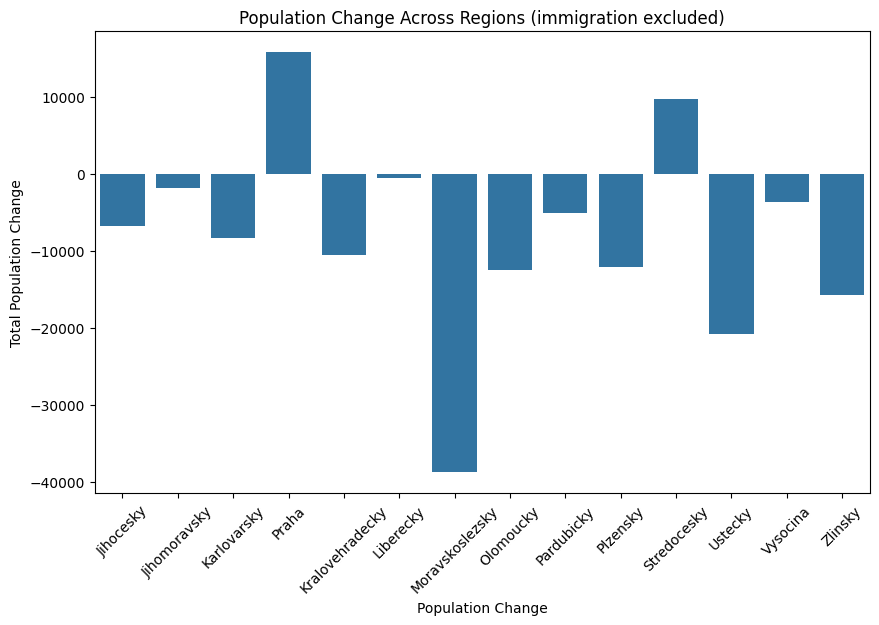

In [7]:
# Population change across regions
total_population_change = {}
for key in uzemi:
    if key == 'CR':
        continue
    deaths = uzemi[key]['Deaths']
    births = uzemi[key]['Births']
    deaths_values, _ = zip(*deaths['Total'])
    births_values, years = zip(*births['Total'])

    deaths_values = np.array(deaths_values, dtype=int)
    births_values = np.array(births_values, dtype=int)

    difference = births_values - deaths_values
    total_population_change[key] = np.sum(difference)

df_population_change = pd.DataFrame(total_population_change.items(), columns=['Region', 'Total Population Change'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Total Population Change', data=df_population_change, estimator=sum)
plt.title('Population Change Across Regions (immigration excluded)')
plt.xticks(rotation=45)
plt.xlabel('Population Change')
plt.show()

*As you can see, if we use the already processed data on population change, that includes the immigration, we recieve comppletely different numbers, much higher ones*

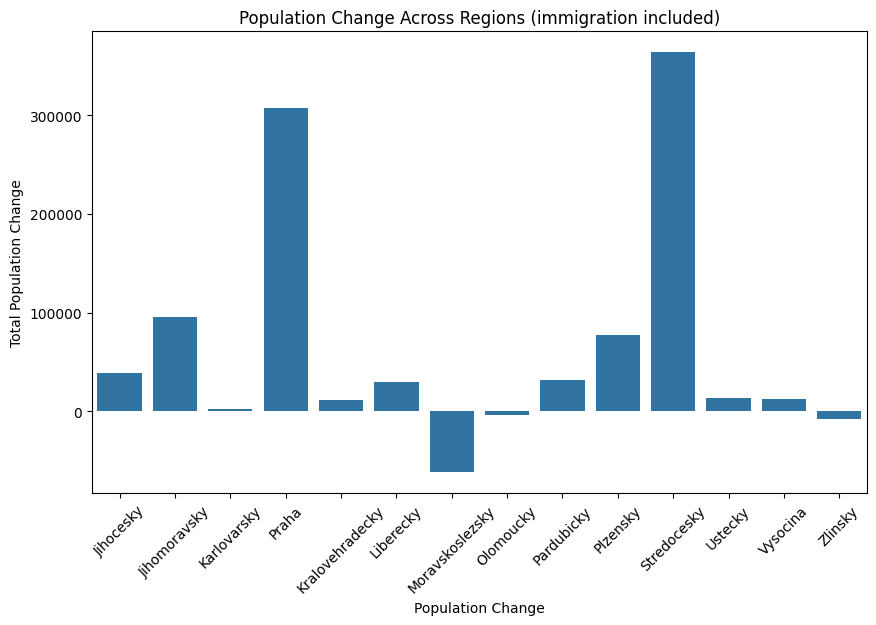

In [8]:
# Population change across regions
total_population_change = {}
for key in uzemi:
    if key == 'CR':
        continue
    population_change = uzemi[key]['Population change']
    population_change_values, _ = zip(*population_change['Total'])
    population_change_values = np.array(population_change_values, dtype=int)
    total_population_change[key] = np.sum(population_change_values)

df_population_change = pd.DataFrame(total_population_change.items(), columns=['Region', 'Total Population Change'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Total Population Change', data=df_population_change, estimator=sum)
plt.title('Population Change Across Regions (immigration included)')
plt.xticks(rotation=45)
plt.xlabel('Population Change')
plt.show()

# Deaths
The graph looks very similar in all of the regions, so it doesn't make sence to plot them all.  

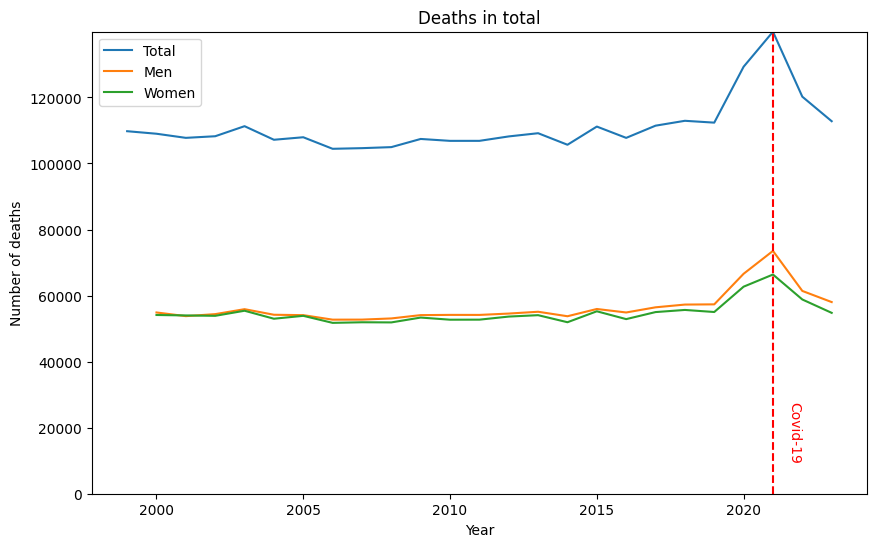

In [9]:
# Total Deaths
deaths = uzemi['CR']['Deaths']

# deaths
i = 0
plt.figure(figsize=(10, 6))
for key in deaths:
    if i == 3:
        break
    # Separate the values and the years into two lists 
    values, years = zip(*deaths[key])
    if key == 'Total':
        max_value = max(values)
    plt.plot(years, values, label=key)
    i += 1


plt.axvline(x=2021, color='red', linestyle='--')
plt.text(2021.5, 10000, 'Covid-19', color='red', rotation=-90)

plt.title('Deaths in total')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.ylim(0, max_value)
plt.legend()
plt.show()

- Covid-19 didn't reach the number of deaths of tumors
- External injuries seem to be pretty low, about 6 000 a year (Probably a younger target group though)

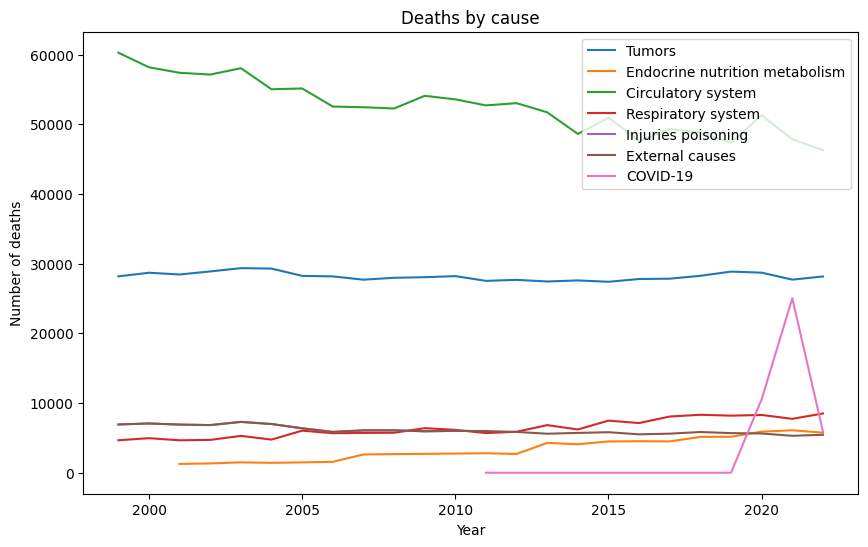

In [10]:
# Deaths by cause
i = 0
plt.figure(figsize=(10, 6))

for key in deaths:
    if i < 3:
        i += 1
        continue
    # Separate the values and the years into two lists 
    values, years = zip(*deaths[key])
    maximum_value = max(values)
    if maximum_value > 6_000:
        plt.plot(years, values, label=key)

plt.title('Deaths by cause')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.legend()
plt.show()

It's interesting how you can see the decrease in deaths between the ages of 15-64, which could indicate the medical development. We can also see the difference in ages related to the Covid-19, where the 65+ age group has significantly higher spike than the 15-64 one and the 0-14 doesn't seem to have a significant change at all (could be because the other groups have so much higher death rate)

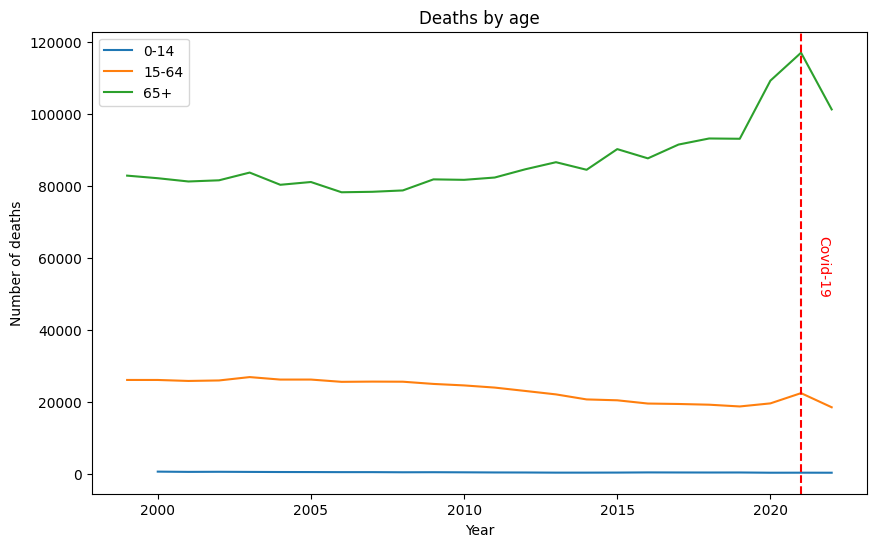

In [11]:
# Deaths by age
deaths_by_age = uzemi['CR']['Deaths by age']
plt.figure(figsize=(10, 6))

for key in deaths_by_age:
    # Separate the values and the years into two lists 
    values, years = zip(*deaths_by_age[key])
    plt.plot(years, values, label=key)

plt.axvline(x=2021, color='red', linestyle='--')
plt.text(2021.5, 50000, 'Covid-19', color='red', rotation=-90)


plt.title('Deaths by age')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.legend()

plt.show()

The difference seems to have an increasing slope, which might be caused by the increase of population in the Czech republic over the years.  
*The only significant spike that seems to be out of order is during the Covid-19 hit, which really surprised me. In the Czech republic, there is about 0.5 M more women than men and more importantly, the women populace is older on average. As we have seen in the previous graph, the most impacted age group by Covid-19 was the 65+ one, so the fact that the gender difference in deaths is even more inclined towards men dying bewildered me. (the change seems to go from about 2000 more men dead to 7000 - about 3.5 times more)*

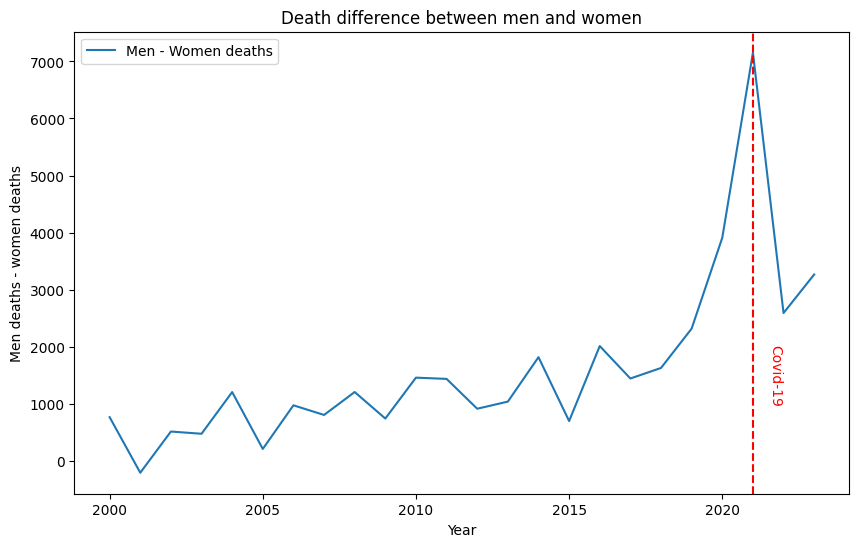

In [12]:
# Death diffence between men and women
men_values, _ = zip(*deaths['Men'])
women_values, years = zip(*deaths['Women'])

men_values = np.array(men_values)
women_values = np.array(women_values)
male_to_female_difference = men_values - women_values

plt.figure(figsize=(10, 6))
plt.plot(years, male_to_female_difference, label='Men - Women deaths')

plt.axvline(x=2021, color='red', linestyle='--')
plt.text(2021.5, 1000, 'Covid-19', color='red', rotation=-90)

plt.title('Death difference between men and women')
plt.xlabel('Year')
plt.ylabel('Men deaths - women deaths')
plt.legend()
plt.show()


# Children births
The current decreasing trend might be caused by the Covid-19 pandemy, the war in Ukraine and or the incresing prices of housing

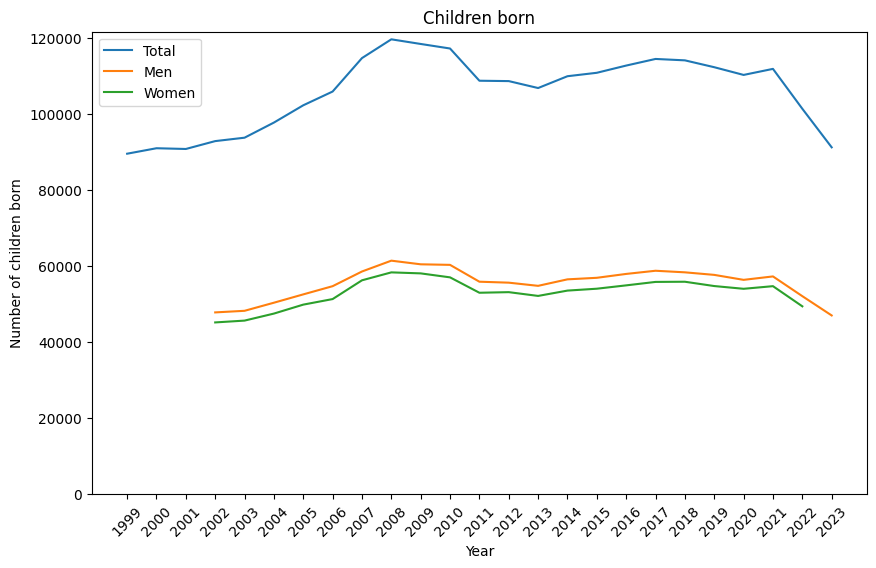

In [13]:
# Children births
children_born = uzemi['CR']['Births']
plt.figure(figsize=(10, 6))
# Separate the values and the years into two lists 
Total_values, years = zip(*children_born['Total'])

i = 0
for key in children_born:
    if i == 3:
        break
    # Separate the values and the years into two lists 
    values, years = zip(*children_born[key])
    plt.plot(years, values, label=key)
    i += 1
plt.title('Children born')
plt.xlabel('Year')
plt.ylabel('Number of children born')
plt.xticks(range(1999, 2024))
plt.xticks(rotation=45)

plt.ylim(0, max(Total_values) + 2000)
plt.legend()
plt.show()

- the number of children born out of wedlock seems to be increasing (A little over half the children now)
- there are about as many first born children as the rest combined

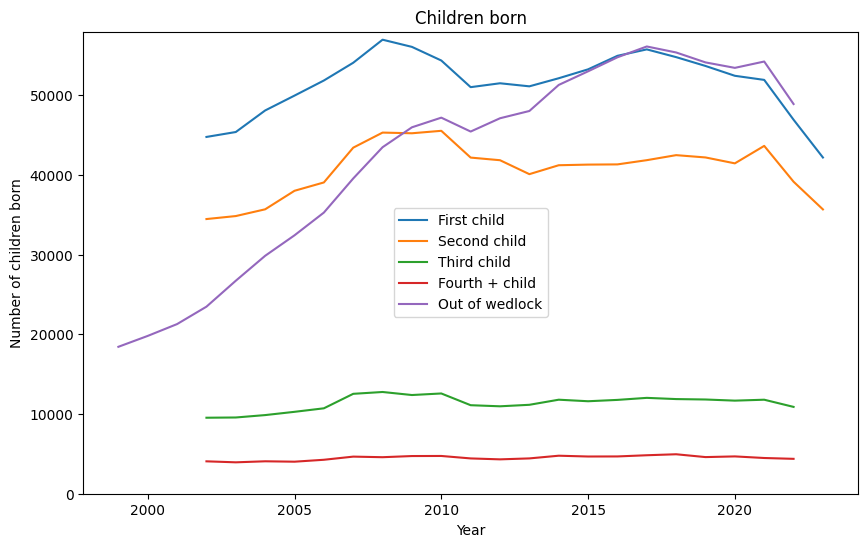

In [14]:
# Children births - additional information
i = 0
max_value = 0
plt.figure(figsize=(10, 6))
for key in children_born:
    if i < 3:
        i += 1
        continue
    # Separate the values and the years into two lists 
    values, years = zip(*children_born[key])
    if max(values) > max_value:
        max_value = max(values)
    plt.plot(years, values, label=key)
plt.ylim(0, max_value + 1000)
plt.title('Children born')
plt.xlabel('Year')
plt.ylabel('Number of children born')
plt.legend()
plt.show()

There doesn't seem to be an increasing trend in gender difference in child births, the ratio of 1050 males to 1000 females seems to be relatively stable

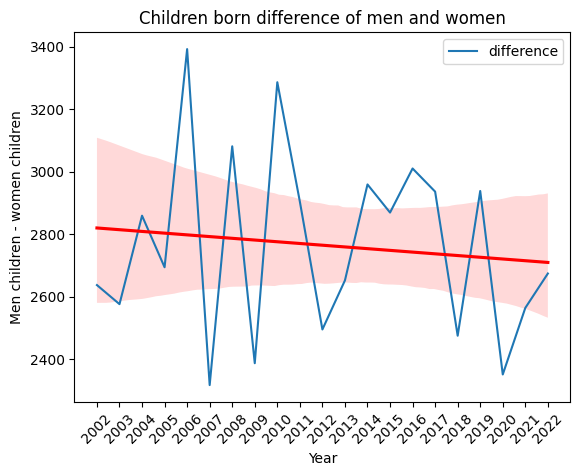

In [15]:
# Birth diffence of men and women
men_values, _ = zip(*children_born['Men'])
men_values = np.array(men_values)[1:]
women_values, years = zip(*children_born['Women'])
women_values = np.array(women_values)
years = np.array(years)

male_to_female_difference = men_values - women_values

plt.plot(years, male_to_female_difference, label='difference')

sns.regplot(x=years, y=male_to_female_difference, scatter=False, color='red')

plt.xticks(range(2002, 2023))
plt.xticks(rotation=45)

plt.title('Children born difference of men and women')
plt.xlabel('Year')
plt.ylabel('Men children - women children')
plt.legend()
plt.show()

## Average age of mothers on birth
As could be expected, the average age of mothers is increasing. Interistingly, the age change seems to be slowing down.

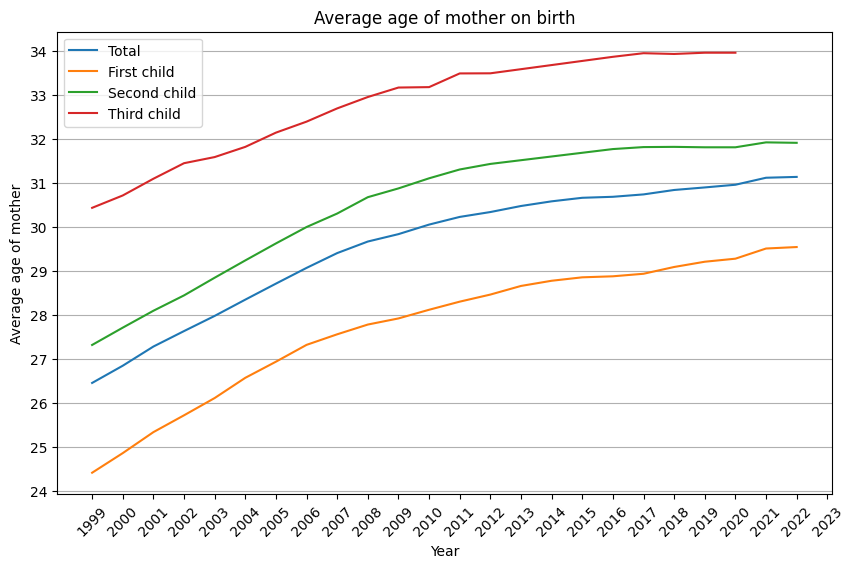

In [16]:
# Average age of mother on birth

age_of_mother = uzemi['CR']['Age of mother on birth']

plt.figure(figsize=(10, 6))

min_value = 100
max_value = 0
for key in age_of_mother:
    # Separate the values and the years into two lists 
    values, years = zip(*age_of_mother[key])
    if max(values) > max_value:
        max_value = max(values)
    if min(values) < min_value:
        min_value = min(values)
    plt.plot(years, values, label=key)

plt.xticks(range(1999, 2024))
plt.xticks(rotation=45)
plt.yticks(range(int(min_value), int(max_value) + 2))
plt.grid(axis='y')
plt.title('Average age of mother on birth')
plt.xlabel('Year')
plt.ylabel('Average age of mother')
plt.legend()

plt.show()

# Abortions
Surprisingly, the number of abortions decreased over the years, even though the number of religious families decreased. (which could indicate an increase in the number of abortions)  
This might be caused by an improving level of contraception.

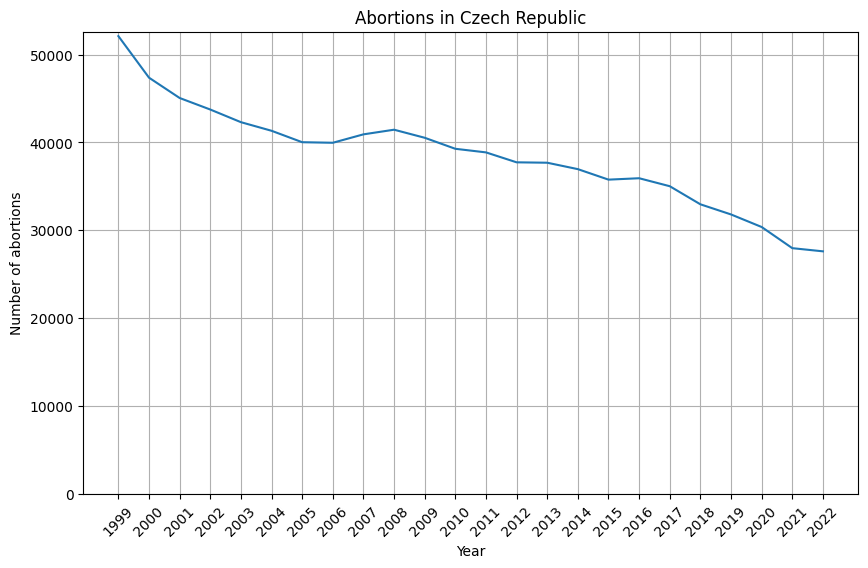

In [17]:
# Abortions
abortions = uzemi['CR']['Abortions']

values, years = zip(*abortions)

values = np.array(values, dtype=int)
years = np.array(years, dtype=int)

max_year = max(years)
min_year = min(years)

max_value = max(values)

plt.figure(figsize=(10, 6))
plt.plot(years, values, label="Number of abortions")

plt.ylim(0, max_value + 500)

plt.xticks(range(min_year, max_year + 1))
plt.xticks(rotation=45)
plt.grid()

plt.title('Abortions in Czech Republic')
plt.xlabel('Year')
plt.ylabel('Number of abortions')

plt.show()

### Mortality rate
Mortality rate has clearly decreasing trend over the years, which should be caused by increased level of medicine.

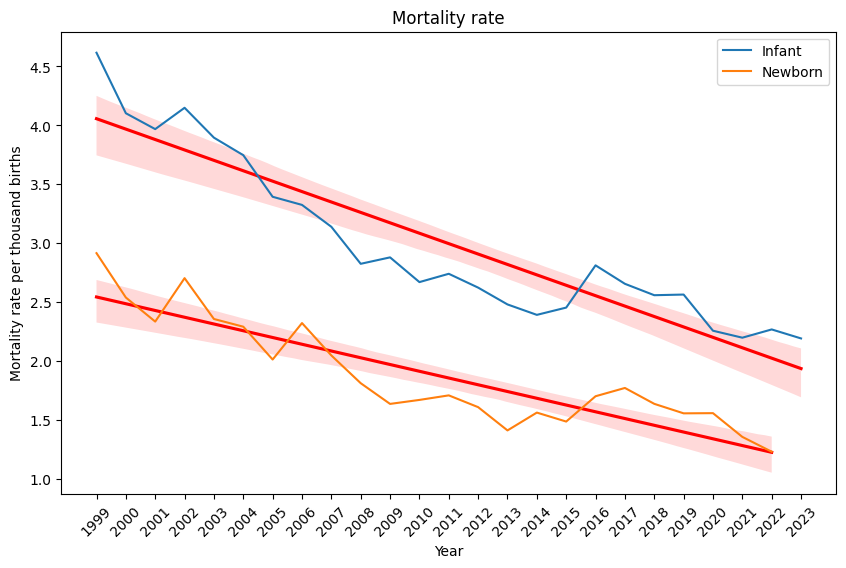

In [18]:
# Mortality rate

mortality_rate = uzemi['CR']['Mortality rate']

plt.figure(figsize=(10, 6))

for key in mortality_rate:
    # Separate the values and the years into two lists 
    values, years = zip(*mortality_rate[key])
    values, years = np.array(values, dtype=float), np.array(years, dtype=int)

    # We can see that the mortality does decline, however, not linearly
    sns.regplot(x=years, y=values, scatter=False, color='red')
    plt.plot(years, values, label=key)

# Set the tick locations for y-axis
plt.xticks(range(1999, 2024))
plt.xticks(rotation=45)
plt.title('Mortality rate')
plt.xlabel('Year')
plt.ylabel('Mortality rate per thousand births')
plt.legend()

plt.show()